## 1. Import libraries and requirements

In [5]:
# Loading required packages
import spacy
import pandas as pd
import re
# import gensim
# import gensim.downloader
# from gensim.models import Word2Vec
# from gensim.test.utils import common_texts
# from gensim.models import Word2Vec
# from gensim.models.phrases import Phrases, Phraser
import nltk
from numpy import mean
from numpy import std
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.dummy import DummyClassifier
from statistics import mean
import json
import csv
import ast
import numpy as np

from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings

from tqdm import tqdm

# Set seed
seed = np.random.seed(1)


# Select Spacy model
# Efficiency
nlp = spacy.load("en_core_web_sm")

# Accuracy
# nlp = spacy.load("en_core_web_trf")

# Change working directory
# %cd '/Users/richardfrissen/Documents/Maastricht University/Thesis/Development/Datasets'

/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
# Define columns and read annotated data
columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'like_num', 'lang', 'sentiment']
data = pd.read_csv('FULL_Annotation_data_output.tsv', sep='\t', nrows=500000, header = None)

In [ ]:
%%time

# Generate linguistic features for each token
def feature_extraction(input_column):
    features = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for i in tqdm(input_column):
        i = str(i)
        doc = nlp(i)
        word = i
        for token in doc:
            features[0].append(token.pos)
            features[1].append(token.ent_type)
            features[2].append(token.is_alpha)
            features[3].append(token.is_ascii)
            features[4].append(token.is_digit)
            features[5].append(token.is_lower)
            features[6].append(token.is_upper)
            features[7].append(token.is_title)
            features[8].append(token.is_punct)
            features[9].append(token.is_space)
            features[10].append(token.like_num)
            features[11].append(token.is_oov)
            features[12].append(token.is_stop)
            features[13].append(token.lang)
            features[14].append(token.sentiment)
            features[15].append(len(word))
    return features

features = feature_extraction(data[0])

In [ ]:
%%time

# Convert list to dataframe
features = pd.DataFrame(features)

# We need to transpose this dataframe first
features = features.transpose()

# We concat the annotated data with the linguistic features
data = pd.concat([data, features], axis=1)
data.columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'lang', 'sentiment', 'word_length']

data.head(10)

In [ ]:
# Optionally the data can be saved to create a checkpoint

data.to_csv('data_features_full_dataset.csv', index = False)

data = pd.read_csv('data_features_full_dataset.csv', nrows = 500000, header = 0)

data.shape

In [ ]:
data.head(10)

In [ ]:
# init word embedding
embedding = TransformerWordEmbeddings('bert-base-cased')

In [ ]:
%%time

# Generate word embeddings for each token

def bert_wordembed(input_column):
    bert_result =[]
    counter = 0
    for i in tqdm(input_column):
        counter = counter +1
        try:
            i = str(i)
            token = Sentence(i)
            embedding.embed(token)
            result_array = token[0].embedding
            result_list = result_array.tolist()
            bert_result.append(result_list)
        except KeyError:
            bert_result.append(np.nan)
        except TypeError: 
            bert_result.append(np.nan)
        except IndexError:
            bert_result.append(np.nan)

    return bert_result


# Bert_Word_Embeddings
word_embedding = bert_wordembed(data['Token'])

In [ ]:
len(word_embedding)

In [ ]:
# Optionally the data can be saved to create a checkpoint

# import pickle

f = open('word_embedding_bert.pckl', 'wb')
pickle.dump(word_embedding, f)
f.close()

f = open('word_embedding_bert.pckl', 'rb')
word_embedding = pickle.load(f)
f.close()

In [ ]:
%%time

# Replace empty values in the list of word embeddings for words 
# we couldn't generate a word embedding for

word_embedding_complete = []

for i in tqdm(word_embedding):
    try:
        if len(i) == 0:
            i = []
        else:
            i = i
        word_embedding_complete.append(i)
        
    except TypeError:
        i = []
        word_embedding_complete.append(i)

In [ ]:
# Check and verify length
# Length must be the same as the nrows of the dataframe

len(word_embedding_complete)

In [ ]:
%%time

# Convert list to dataframe
word_embedding_df = pd.DataFrame(word_embedding_complete)
word_embedding_series = word_embedding_df.apply(pd.Series)

# We concat the annotated data with the linguistic features
data = pd.concat([data, word_embedding_series], axis=1)

In [ ]:
data.head(10)

In [7]:
%%time

# Optionally the data can be saved to create a checkpoint

# data.to_csv('data_features_full_wordembedding_bert.csv', index = False)

data = pd.read_csv('data_features_full_wordembedding_bert.csv', nrows=500000, na_values=['nan'])

data.head(10)

CPU times: user 1min 14s, sys: 6.42 s, total: 1min 20s
Wall time: 1min 29s


,Token,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,...,758,759,760,761,762,763,764,765,766,767
0,food,O,92,0,True,True,False,True,False,False,...,0.078347,-0.213393,-0.360482,0.599680,0.611853,0.220767,0.342419,0.055093,0.177906,0.719633
1,a,O,90,0,True,True,False,True,False,False,...,0.005257,0.682079,-0.566330,0.124105,0.314677,-0.002286,0.631670,0.115115,1.044015,0.560535
2,fast,O,86,0,True,True,False,True,False,False,...,0.577659,0.032252,-0.028243,0.251337,-1.222422,1.028620,0.959377,-0.790838,0.316029,0.436458
3,grow,O,100,0,True,True,False,True,False,False,...,-0.717857,-0.141034,-0.484016,0.332784,0.141271,0.088913,-0.936067,-0.500807,0.084751,0.278871
4,-winne,O,97,0,False,True,False,True,False,False,...,0.076417,0.086553,-0.706749,0.188063,0.195960,0.284505,0.606089,0.832055,0.249324,0.395537
5,online,O,86,0,True,True,False,True,False,False,...,0.015824,-0.081609,-0.880314,0.047720,-0.266453,0.458979,0.197704,-0.666143,0.375859,0.119397
6,food,O,92,0,True,True,False,True,False,False,...,0.078347,-0.213393,-0.360482,0.599680,0.611853,0.220767,0.342419,0.055093,0.177906,0.719633
7,community,O,92,0,True,True,False,True,False,False,...,-0.400877,0.182614,-1.512862,0.898749,-1.064716,-0.387649,-0.566761,-0.220441,-0.061128,-0.138970
8,and,O,89,0,True,True,False,True,False,False,...,0.209402,0.291369,-0.166621,0.138620,0.343412,0.192610,0.490048,-0.279343,0.030398,0.067056
9,crowd,O,92,0,True,True,False,True,False,False,...,0.374465,0.081873,-0.957627,-0.046060,-0.142485,0.079933,0.037512,-0.538567,-0.155005,0.147617


In [8]:
len(data)

500000

In [9]:
%%time

# Replace NaN values with a "0"

data = data.replace(np.nan, '0', regex=True)

# We drop the token, as it is no longer needed for prediction
data.drop('Token', axis=1, inplace=True)
data.head(10)

CPU times: user 35.5 s, sys: 9.67 s, total: 45.1 s
Wall time: 45.5 s


,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,is_punct,...,758,759,760,761,762,763,764,765,766,767
0,O,92,0,True,True,False,True,False,False,False,...,0.078347,-0.213393,-0.360482,0.59968,0.611853,0.220767,0.342419,0.055093,0.177906,0.719633
1,O,90,0,True,True,False,True,False,False,False,...,0.005257,0.682079,-0.56633,0.124105,0.314677,-0.002286,0.63167,0.115115,1.044015,0.560535
2,O,86,0,True,True,False,True,False,False,False,...,0.577659,0.032252,-0.028243,0.251337,-1.222422,1.02862,0.959377,-0.790838,0.316029,0.436458
3,O,100,0,True,True,False,True,False,False,False,...,-0.717857,-0.141034,-0.484016,0.332784,0.141271,0.088913,-0.936067,-0.500807,0.084751,0.278871
4,O,97,0,False,True,False,True,False,False,False,...,0.076417,0.086553,-0.706749,0.188063,0.19596,0.284505,0.606089,0.832055,0.249324,0.395537
5,O,86,0,True,True,False,True,False,False,False,...,0.015824,-0.081609,-0.880314,0.04772,-0.266453,0.458979,0.197704,-0.666143,0.375859,0.119397
6,O,92,0,True,True,False,True,False,False,False,...,0.078347,-0.213393,-0.360482,0.59968,0.611853,0.220767,0.342419,0.055093,0.177906,0.719633
7,O,92,0,True,True,False,True,False,False,False,...,-0.400877,0.182614,-1.512862,0.898749,-1.064716,-0.387649,-0.566761,-0.220441,-0.061128,-0.13897
8,O,89,0,True,True,False,True,False,False,False,...,0.209402,0.291369,-0.166621,0.13862,0.343412,0.19261,0.490048,-0.279343,0.030398,0.067056
9,O,92,0,True,True,False,True,False,False,False,...,0.374465,0.081873,-0.957627,-0.04606,-0.142485,0.079933,0.037512,-0.538567,-0.155005,0.147617


In [10]:
%%time

# 80% / 20% split
# Train, Test = train_test_split(data1, test_size=0.2, shuffle=False)

X = data.drop(['Label'],axis=1).values # independant features
y = data['Label'].values # dependant variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

CPU times: user 20.5 s, sys: 7.7 s, total: 28.2 s
Wall time: 28.5 s


In [29]:
X_train.shape, y_train.shape

((49902, 316), (49902,))

In [30]:
X_test.shape, y_test.shape

((100000, 316), (100000,))

In [32]:
%%time

max_iterations = 1000000000

classifier = []
accuracy = []
precision = []
recall = []
f1 = []

CPU times: user 8 µs, sys: 4 µs, total: 12 µs
Wall time: 22.2 µs


In [26]:
%%time
# Baseline

clf = DummyClassifier(strategy="uniform", random_state=seed)


# Model fit
clf.fit(X_train, y_train)

CPU times: user 28.6 ms, sys: 1.66 ms, total: 30.2 ms
Wall time: 29.8 ms


DummyClassifier(strategy='uniform')

In [27]:
# Optionally the data can be saved to create a checkpoint - Baseline

import pickle

f = open('bert_baseline_resample.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_baseline_resample.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.16662
Precision: 0.16669788143411368
Recall: 0.16315833387324433
F1_score: 0.05833372562723548


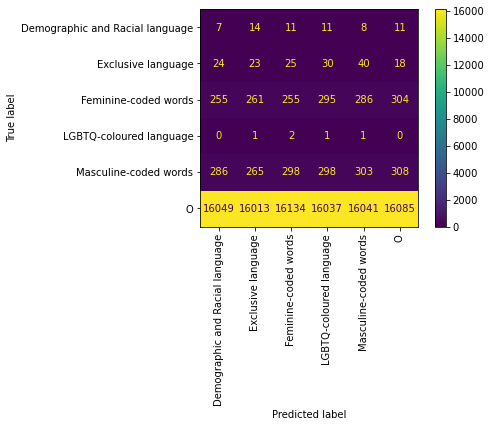

                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.15      0.00        62
             Exclusive language       0.00      0.13      0.00       160
           Feminine-coded words       0.02      0.18      0.03      1656
        LGBTQ-coloured language       0.00      0.20      0.00         5
          Masculine-coded words       0.02      0.15      0.03      1758
                              O       0.96      0.17      0.28     96359

                       accuracy                           0.17    100000
                      macro avg       0.17      0.16      0.06    100000
                   weighted avg       0.93      0.17      0.27    100000



In [28]:
# Evaluation Baseline

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("Baseline")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [11]:
%%time

# Find optimal SVM parameters

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': ('linear', 'rbf', 'poly', 'sigmoid')}
# grid_search = GridSearchCV(svm.SVC(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 19.8 µs


In [12]:
%%time
# Support Vector Machine
# best: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = svm.SVC(kernel='rbf', random_state=seed, max_iter=max_iterations, C=10, gamma=1)
scores_SVM = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
SVM_avg_precision = mean(scores_SVM['test_precision_macro'])
SVM_avg_recall = mean(scores_SVM['test_recall_macro'])
SVM_avg_f1 = mean(scores_SVM['test_f1_macro'])

print(SVM_avg_precision)
print(SVM_avg_recall)
print(SVM_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9661804815333659
0.8227523008085689
0.8800915231010064
CPU times: user 1h 24min 12s, sys: 2min 19s, total: 1h 26min 32s
Wall time: 3h 48min 2s


SVC(C=10, gamma=1, max_iter=1000000000)

In [12]:
# Optionally the data can be saved to create a checkpoint - SVM

import pickle

f = open('bert_svm.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_svm.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.99742
Precision: 0.9995549437469596
Recall: 0.8547160441822711
F1_score: 0.9156931969562628


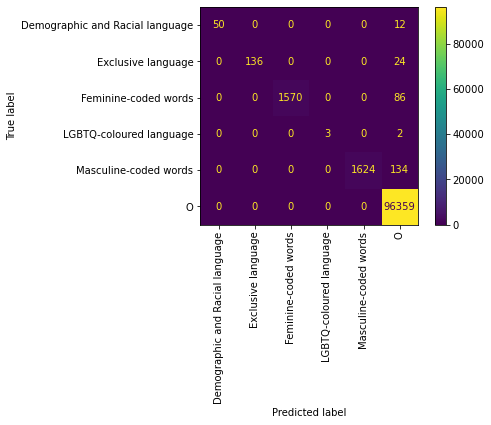

                                 precision    recall  f1-score   support

Demographic and Racial language       1.00      0.81      0.89        62
             Exclusive language       1.00      0.85      0.92       160
           Feminine-coded words       1.00      0.95      0.97      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       1.00      0.92      0.96      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       1.00      0.85      0.92    100000
                   weighted avg       1.00      1.00      1.00    100000



In [13]:
# Evaluation Support Vector Machine

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("SVM")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [15]:
%%time

# Find optimal Logistic Regression settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# penaltys = ['l1', 'l2', 'elasticnet']
# param_grid = {'C': Cs, 'penalty' : penaltys, 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
# grid_search = GridSearchCV(LogisticRegression(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [16]:
%%time

# Logistic Regression

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = LogisticRegression(solver='newton-cg', random_state=seed, max_iter=max_iterations)
scores_LR = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
LR_avg_precision = mean(scores_LR['test_precision_macro'])
LR_avg_recall = mean(scores_LR['test_recall_macro'])
LR_avg_f1 = mean(scores_LR['test_f1_macro'])

print(LR_avg_precision)
print(LR_avg_recall)
print(LR_avg_f1)

# Model fit
clf.fit(X_train, y_train)

IOStream.flush timed out
/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line

0.16036208333333332
0.16666666666666666
0.16345360393227235
CPU times: user 2h 47min 33s, sys: 1h 49min 26s, total: 4h 37min
Wall time: 19min 4s


/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


LogisticRegression(max_iter=1000000000, solver='newton-cg')

In [14]:
# Optionally the data can be saved to create a checkpoint - LR

import pickle

f = open('bert_lr.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_lr.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.96359
Precision: 0.16059833333333332
Recall: 0.16666666666666666
F1_score: 0.1635762387599584


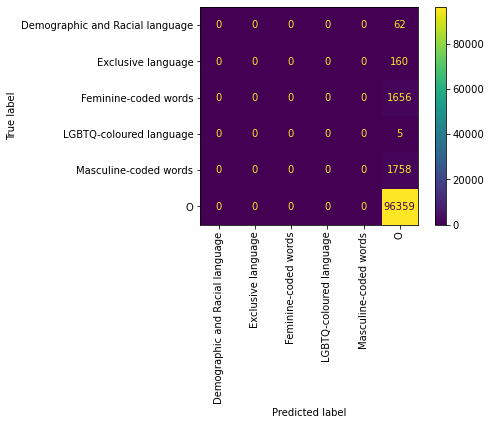

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.00      0.00      0.00      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       0.96      1.00      0.98     96359

                       accuracy                           0.96    100000
                      macro avg       0.16      0.17      0.16    100000
                   weighted avg       0.93      0.96      0.95    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Evaluation Logistic Regression

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("LR")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [19]:
%%time

# Decision Tree

# Cross validation
scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = DecisionTreeClassifier(random_state=seed)
scores_DT = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
DT_avg_precision = mean(scores_DT['test_precision_macro'])
DT_avg_recall = mean(scores_DT['test_recall_macro'])
DT_avg_f1 = mean(scores_DT['test_f1_macro'])

print(DT_avg_precision)
print(DT_avg_recall)
print(DT_avg_f1)

# Model fit
clf.fit(X_train, y_train)

0.9748942917788961
0.9903588506597816
0.9818714672402753
CPU times: user 40min 19s, sys: 2min 2s, total: 42min 21s
Wall time: 1h 24min 57s


DecisionTreeClassifier()

In [16]:
# Optionally the data can be saved to create a checkpoint - DT

import pickle

f = open('bert_dt.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_dt.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.99935
Precision: 0.900759665351825
Recall: 0.929819490157199
F1_score: 0.9146298892129611


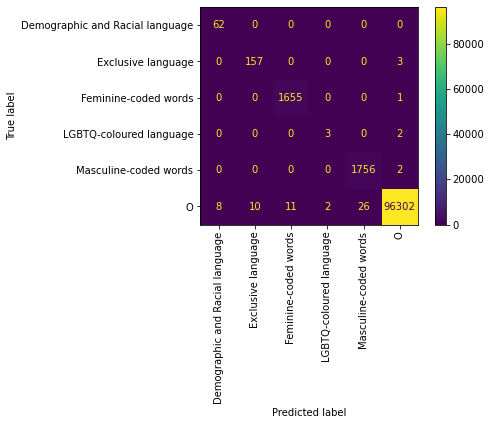

                                 precision    recall  f1-score   support

Demographic and Racial language       0.89      1.00      0.94        62
             Exclusive language       0.94      0.98      0.96       160
           Feminine-coded words       0.99      1.00      1.00      1656
        LGBTQ-coloured language       0.60      0.60      0.60         5
          Masculine-coded words       0.99      1.00      0.99      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       0.90      0.93      0.91    100000
                   weighted avg       1.00      1.00      1.00    100000



In [17]:
# Evaluation Decision Tree

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("DT")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [33]:
%%time

# Random Forest

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = RandomForestClassifier(random_state=seed)
scores_RF = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
RF_avg_precision = mean(scores_RF['test_precision_macro'])
RF_avg_recall = mean(scores_RF['test_recall_macro'])
RF_avg_f1 = mean(scores_RF['test_f1_macro'])

print(RF_avg_precision)
print(RF_avg_recall)
print(RF_avg_f1)

# Model fit
clf.fit(X_train, y_train)

0.99963733134234
0.9995266864468606
0.9995814760358668
CPU times: user 34.3 s, sys: 26.6 s, total: 1min
Wall time: 1min 19s


RandomForestClassifier()

In [34]:
# Optionally the data can be saved to create a checkpoint - RF

import pickle

f = open('fasttext_rf_resample.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_rf_resample.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.99979
Precision: 0.9961769006570407
Recall: 0.9298955944477513
F1_score: 0.9546769677204449


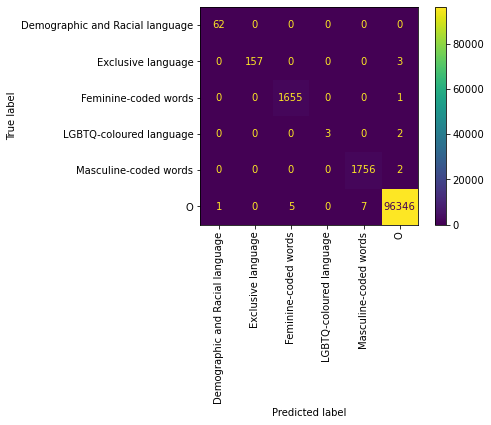

                                 precision    recall  f1-score   support

Demographic and Racial language       0.98      1.00      0.99        62
             Exclusive language       1.00      0.98      0.99       160
           Feminine-coded words       1.00      1.00      1.00      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       1.00      1.00      1.00      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       1.00      0.93      0.95    100000
                   weighted avg       1.00      1.00      1.00    100000



In [35]:
# Evaluation Random Forest

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("RF")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal Neural network MLP settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# activations = ['identity', 'logistic', 'tanh', 'relu']
# alphas = [0.0001, 0.001, 00.1, 0.1, 1]
# param_grid = {'activation': activations, 'alpha' : alphas, 'solver': ('lbfgs', 'sgd', 'adam'), 'learning_rate': ('constant', 'invscaling', 'adaptive')}
# grid_search = GridSearchCV(MLPClassifier(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [26]:
%%time

# Neural network MLP

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = MLPClassifier(solver='adam', random_state=seed)
scores_NN = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NN_avg_precision = mean(scores_NN['test_precision_macro'])
NN_avg_recall = mean(scores_NN['test_recall_macro'])
NN_avg_f1 = mean(scores_NN['test_f1_macro'])

print(NN_avg_precision)
print(NN_avg_recall)
print(NN_avg_f1)

# Model fit
clf.fit(X_train, y_train)

IOStream.flush timed out
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: U

0.16036208333333332
0.16666666666666666
0.16345360393227235
CPU times: user 2h 35min 33s, sys: 5h 43min 42s, total: 8h 19min 15s
Wall time: 20min 49s


MLPClassifier()

In [20]:
# Optionally the data can be saved to create a checkpoint - MLP

import pickle

f = open('bert_mlp.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_mlp.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.96359
Precision: 0.16059833333333332
Recall: 0.16666666666666666
F1_score: 0.1635762387599584


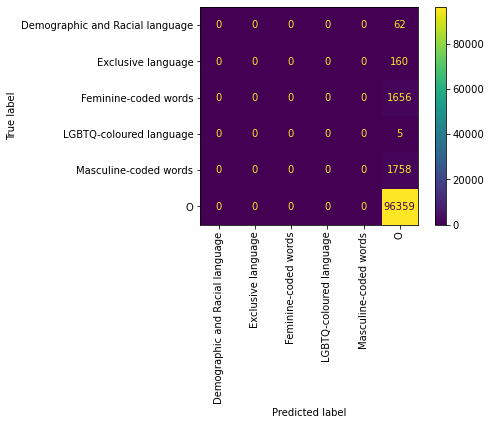

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.00      0.00      0.00      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       0.96      1.00      0.98     96359

                       accuracy                           0.96    100000
                      macro avg       0.16      0.17      0.16    100000
                   weighted avg       0.93      0.96      0.95    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Evaluation Neural network MLP

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("MLP")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [29]:
%%time

# Naive Bayes

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = GaussianNB()
scores_NB = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NB_avg_precision = mean(scores_NB['test_precision_macro'])
NB_avg_recall = mean(scores_NB['test_recall_macro'])
NB_avg_f1 = mean(scores_NB['test_f1_macro'])

print(NB_avg_precision)
print(NB_avg_recall)
print(NB_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Pr

0.11970472004188243
0.16667446151773477
0.005982920730818852
CPU times: user 2min 40s, sys: 1min 49s, total: 4min 30s
Wall time: 5min 39s


GaussianNB()

In [22]:
# Optionally the data can be saved to create a checkpoint - NB

import pickle

f = open('bert_nb.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_nb.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.0166
Precision: 0.16942677707108286
Recall: 0.16667358523853507
F1_score: 0.005444128152409039


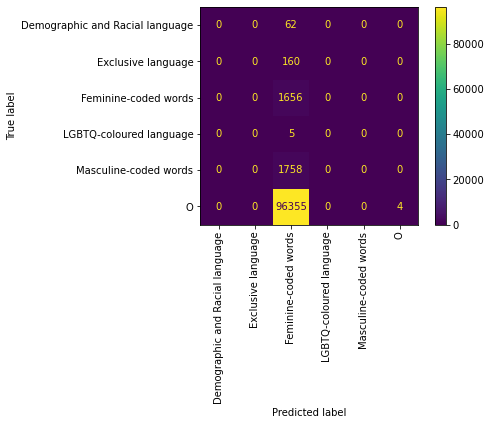

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.02      1.00      0.03      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       1.00      0.00      0.00     96359

                       accuracy                           0.02    100000
                      macro avg       0.17      0.17      0.01    100000
                   weighted avg       0.96      0.02      0.00    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Evaluation Naive Bayes

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("NB")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [24]:
results = pd.DataFrame(zip(classifier, accuracy, precision, recall, f1), columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
results = results.sort_values(by = "F1-score", ascending = False)

f = open('bert_results.pckl', 'wb')
pickle.dump(results, f)
f.close()

f = open('bert_results.pckl', 'rb')
results = pickle.load(f)
f.close()

print(results)

  Classifier  Accuracy  Precision    Recall  F1-score
4         RF   0.99992   0.999986  0.929918  0.956604
1        SVM   0.99742   0.999555  0.854716  0.915693
3         DT   0.99935   0.900760  0.929819  0.914630
2         LR   0.96359   0.160598  0.166667  0.163576
5        MLP   0.96359   0.160598  0.166667  0.163576
0   Baseline   0.16662   0.166698  0.163158  0.058334
6         NB   0.01660   0.169427  0.166674  0.005444


In [26]:
# Save results dataframe

results.to_csv('bert_results.csv', index = False)